In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import decomposition
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# the training arrayCGH dataset simplified
df_training = pd.read_csv('data/training_df.csv', index_col=0)

# the NClone data extracted from the arrayCGH dataset
df_nclone = pd.read_csv('data/n_clone.csv', index_col=0)

# the training class labels
df_labels = pd.read_table('data/labels.txt', index_col=0)

In [ ]:
# Initialize a dictionary to store ROC values
multi_class_roc_values = {}

def plotAvgCM(cms, method):
    """Function to plot the average confusion matrix"""

    # Concatenate confusion matrices and group by index
    cm_concat = pd.concat(cms)
    cm_group = cm_concat.groupby(cm_concat.index)

    # Plot the average confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_group.mean().round(0), annot=True)
    plt.title('Average Confusion Matrix: ' + method)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

## NClone

In [78]:
# select columns from n_clone at different thresholds and use these to filter at different n_clone thresholds (50-500)

# create a dictionary
n_clone_columns = {}

# loop over the thresholds
for threshold in [50, 100, 200, 300, 400, 500]:
  
  # get a list of columns with n_clone greater than the threshold
  columns = df_nclone.columns[(df_nclone > threshold).any()].to_list()

  # add the list to the other list
  n_clone_columns[threshold] = columns

# now we have a dictionary with each threshold and a list of columns at each threshold
# we can try a cross-validation procedure where we try each threshold 5 times

# create a random forest classifier
rf_classifier = RandomForestClassifier()

# for each threshold value, it gets the columns above this value
for threshold, columns in n_clone_columns.items():

    # filter the columns in the dataset with this threshold
    X_subset = df_training[columns]

    # run a 5 fold cross validation
    # this means that the data is split into 5 groups, 4 groups are used to train and 1 group is used to test
    # 5 Random Forests are created with these filtered columns and their accuracy is saved
    scores = cross_val_score(rf_classifier, X_subset, df_labels['Subgroup'], cv = 5, scoring='accuracy')

    # get the average of the 5 accuracy scores
    accuracy = scores.mean()

    # print the scores
    print(f'N_Clone threshold: {threshold},  Accuracy: {accuracy}')

    # we see that the accuracy goes down with a higher threshold
    # accuracy measures the proportion of correctly classified instances out of all instances
    # a score of 0.8, for example, would mean that the model correctly classified 80% of the instances in that particular fold

N_Clone threshold: 50,  Accuracy: 0.65
N_Clone threshold: 100,  Accuracy: 0.67
N_Clone threshold: 200,  Accuracy: 0.5800000000000001
N_Clone threshold: 300,  Accuracy: 0.5
N_Clone threshold: 400,  Accuracy: 0.53
N_Clone threshold: 500,  Accuracy: 0.49000000000000005


In [79]:
# we can try with lower values a second time maybe

# create a dictionary
n_clone_columns = {}

# loop over the thresholds
for threshold in [10, 20, 30, 40, 50]:
  
  # get a list of columns with n_clone greater than the threshold
  columns = df_nclone.columns[(df_nclone > threshold).any()].to_list()

  # add the list to the other list
  n_clone_columns[threshold] = columns

# create a random forest classifier
rf_classifier = RandomForestClassifier()

# for each threshold value, it gets the columns above this value
for threshold, columns in n_clone_columns.items():

    # filter the columns in the dataset with this threshold
    X_subset = df_training[columns]

    # run a 5 fold cross validation
    # this means that the data is split into 5 groups, 4 groups are used to train and 1 group is used to test
    # 5 Random Forests are created with these filtered columns and their accuracy is saved
    scores = cross_val_score(rf_classifier, X_subset, df_labels['Subgroup'], cv = 5, scoring = 'accuracy')

    # get the average of the 5 accuracy scores
    accuracy = scores.mean()

    # print the scores
    print(f'N_Clone threshold: {threshold},  Accuracy: {accuracy}')

    # we see that we have the best accuracy with an n_clone of 20
    # accuracy measures the proportion of correctly classified instances out of all instances
    # a score of 0.8, for example, would mean that the model correctly classified 80% of the instances in that particular fold

N_Clone threshold: 10,  Accuracy: 0.75
N_Clone threshold: 20,  Accuracy: 0.74
N_Clone threshold: 30,  Accuracy: 0.65
N_Clone threshold: 40,  Accuracy: 0.63
N_Clone threshold: 50,  Accuracy: 0.65


It's important to note that we have not done any hyperparameter tuning. Hyperparameter tuning finds the best settings for the model (Random Forest). We can do this with cross validation as well. I used this GitHub link to create a nested CV.

(https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
(https://github.com/rosscleung/Projects/blob/b9abc20db545d9f483e90a9b046ea50c74f25718/Tutorial%20notebooks/Nested%20Cross%20Validation%20Example.ipynb).


1. For each N_clone threshold, the data is broken into 3 (3 fold CV). So for a threshold of n_clone > 20, the data is then broken into 3 groups.

2. Within hyperparameter search, the data is split in half (2 fold CV). So we are using 1/2 of 2/3 of the data.

3. The results of each fold are saved. So for each threshold, there will be three runs. Each run will split the data in half and do hyperparameter searching. The best hyperparameters are saved. so for each threshold, we get 3 best hyperparameter options.

In [81]:
# Define the outer and inner cross-validation splits
outer_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
inner_kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

# Define the hyperparameters grid to search over
params = {'max_depth': [3, 5, 7, None], 'n_estimators': [50, 100, 150, 200]}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=1)

# Initialize dictionaries to store results for each threshold
outer_loop_accuracy_scores = {}
inner_loop_won_params = {}
inner_loop_accuracy_scores = {}

# Iterate over each threshold and associated columns
for threshold in n_clone_columns.keys():

    # Initialize dictionaries for this threshold
    outer_loop_accuracy_scores[threshold] = {}
    inner_loop_won_params[threshold] = {}
    inner_loop_accuracy_scores[threshold] = {}

# Iterate over each threshold and associated columns
for threshold, columns in n_clone_columns.items():

    # Select the subset of features based on the columns
    X_subset = df_training[columns]

    # Run a 3-fold outer cross-validation loop on this threshold value
    for i, (train_index, test_index) in enumerate(outer_kf.split(X_subset, df_labels['Subgroup'])):
        
        # Run a 2-fold inner cross-validation loop to try hyperparameters
        GSCV = GridSearchCV(estimator=rf_classifier, param_grid=params, cv=inner_kf)
        GSCV.fit(X_subset.loc[X_subset.index[train_index]], df_labels.loc[df_labels.index[train_index], 'Subgroup'])
        pred = GSCV.predict(X_subset.loc[X_subset.index[test_index]])

        # Store the best hyperparameters found during inner CV
        inner_loop_won_params[threshold][i] = GSCV.best_params_
        
        # Store the accuracy score of the outer fold
        outer_loop_accuracy_scores[threshold][i] = accuracy_score(df_labels.loc[df_labels.index[test_index], 'Subgroup'], pred)
        
        # Store the mean cross-validation score of the inner CV
        inner_loop_accuracy_scores[threshold][i] = GSCV.best_score_

# Print the results for each threshold
for threshold in n_clone_columns.keys():
    print('For threshold: ', threshold)

    # Print the best hyperparameters, outer loop accuracy score, and mean inner loop accuracy score
    for i in zip(inner_loop_won_params[threshold].values(),
                 outer_loop_accuracy_scores[threshold].values(),
                 inner_loop_accuracy_scores[threshold].values()):
        print(i)
    
    # Print the mean of the outer loop accuracy scores for this threshold
    print(f'Mean of outer loop accuracy score: {np.mean(list(outer_loop_accuracy_scores[threshold].values()))}\n')

For threshold:  10
({'max_depth': 5, 'n_estimators': 150}, 0.7941176470588235, 0.7424242424242424)
({'max_depth': 7, 'n_estimators': 50}, 0.5757575757575758, 0.7455436720142603)
({'max_depth': 3, 'n_estimators': 150}, 0.7272727272727273, 0.6278966131907309)
Mean of outer loop accuracy score: 0.6990493166963755

For threshold:  20
({'max_depth': 5, 'n_estimators': 150}, 0.7352941176470589, 0.696969696969697)
({'max_depth': None, 'n_estimators': 100}, 0.5151515151515151, 0.7156862745098038)
({'max_depth': 3, 'n_estimators': 150}, 0.7272727272727273, 0.6573083778966132)
Mean of outer loop accuracy score: 0.6592394533571004

For threshold:  30
({'max_depth': 7, 'n_estimators': 200}, 0.7647058823529411, 0.6666666666666666)
({'max_depth': 3, 'n_estimators': 50}, 0.48484848484848486, 0.6706773618538324)
({'max_depth': 5, 'n_estimators': 200}, 0.6363636363636364, 0.553030303030303)
Mean of outer loop accuracy score: 0.6286393345216874

For threshold:  40
({'max_depth': 5, 'n_estimators': 200},

Second CV Method to pick best threshold. This method below works similarly. It breaks the data up into the 3 folds, then loops over the different thresholds. For each threshold, it does hyperparameter tuning. At the end of the fold, it chooses the best threshold (threshold with best accuracy) and then uses its hyperparameters to test the left out fold. This means we get three test sets and can average the accuracy of them to get a final approximation of the accuracy.

Fold:  0 Best score:  0.7424242424242424 Best threshold:  10 Best parameters:  {'max_depth': 5, 'n_estimators': 150}
Fold:  1 Best score:  0.7455436720142603 Best threshold:  10 Best parameters:  {'max_depth': 7, 'n_estimators': 50}
Fold:  2 Best score:  0.6573083778966132 Best threshold:  20 Best parameters:  {'max_depth': 3, 'n_estimators': 150}
{10: {0: 0.7424242424242424, 1: 0.7455436720142603, 2: 0.6278966131907309}, 20: {0: 0.696969696969697, 1: 0.7156862745098038, 2: 0.6573083778966132}, 30: {0: 0.6666666666666666, 1: 0.6706773618538324, 2: 0.553030303030303}, 40: {0: 0.6666666666666667, 1: 0.7000891265597148, 2: 0.5975935828877006}, 50: {0: 0.6060606060606061, 1: 0.6706773618538324, 2: 0.6127450980392157}}
Accuracies of three test runs: {0: [0.7941176470588235, 10], 1: [0.5757575757575758, 10], 2: [0.7272727272727273, 20]}
Average of three runs: 7.016191325014854


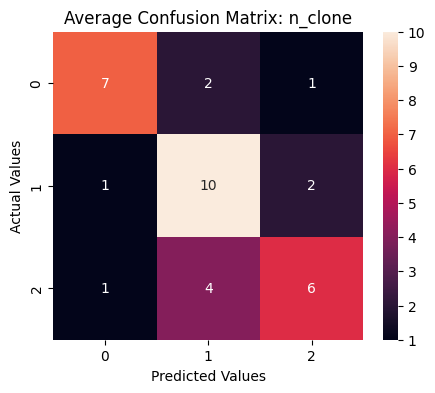

In [85]:
# Initialize StratifiedKFold for outer and inner cross-validation
outer_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
inner_kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

# Define the hyperparameters grid to search over
params = {'max_depth': [3, 5, 7, None], 'n_estimators': [50, 100, 150, 200]}

# Initialize a RandomForestClassifier for hyperparameter tuning
rf_classifier = RandomForestClassifier(random_state=1)

# Initialize dictionaries to store results for each fold and each threshold
outer_loop_accuracy_scores = {}
inner_loop_won_params = {}
inner_loop_accuracy_scores = {}
confusion_matrices = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Initialize dictionaries for inner loop parameters and accuracy scores for each threshold
for threshold in [10, 20, 30, 40, 50]:
    inner_loop_won_params[threshold] = {}
    inner_loop_accuracy_scores[threshold] = {}

# Iterate over each fold of outer cross-validation
for i, (train_index, test_index) in enumerate(outer_kf.split(df_training, df_labels['Subgroup'])):

    # Iterate over each n_clone threshold
    for threshold in [10, 20, 30, 40, 50]:

        # Get a list of columns with n_clone values greater than the threshold
        columns = df_nclone.columns[(df_nclone > threshold).any()].to_list()

        # Filter the training dataset based on the columns selected
        X_subset = df_training[columns]
        
        # Run a 2-fold inner cross-validation to try hyperparameters
        GSCV = GridSearchCV(estimator=rf_classifier, param_grid=params, cv=inner_kf)
        GSCV.fit(X_subset.loc[X_subset.index[train_index]], df_labels.loc[df_labels.index[train_index], 'Subgroup'])

        # Store the best hyperparameters and corresponding accuracy score
        inner_loop_won_params[threshold][i] = GSCV.best_params_
        inner_loop_accuracy_scores[threshold][i] = GSCV.best_score_

    # Get the threshold with the best score for this fold and its corresponding hyperparameters
    best_score = 0
    best_threshold = 0
    for thresh in inner_loop_accuracy_scores:
        if inner_loop_accuracy_scores[thresh][i] > best_score:
            best_score = inner_loop_accuracy_scores[thresh][i]
            best_threshold = thresh

    # Run the model with the best threshold and hyperparameters on the test set, and record the accuracy
    print('Fold: ', i, 'Best score: ', best_score, 'Best threshold: ', best_threshold, 'Best parameters: ', inner_loop_won_params[best_threshold][i])
    rf_classifier = RandomForestClassifier(**inner_loop_won_params[best_threshold][i], random_state=1)
    final_train_data = df_training[df_nclone.columns[(df_nclone > best_threshold).any()]].loc[df_training.index[train_index]]
    final_test_data = df_training[df_nclone.columns[(df_nclone > best_threshold).any()]].loc[df_training.index[test_index]]
    rf_classifier.fit(final_train_data, df_labels.loc[df_labels.index[train_index], 'Subgroup'])
    y_pred = rf_classifier.predict(final_test_data)
    outer_loop_accuracy_scores[i] = [accuracy_score(df_labels.loc[df_labels.index[test_index], 'Subgroup'], y_pred), best_threshold]
    confusion_matrices.append(pd.DataFrame(confusion_matrix(df_labels.loc[df_labels.index[test_index], 'Subgroup'], y_pred)))

    # Saving Values for ROC
    y_test_bin = label_binarize(df_labels.loc[df_labels.index[test_index], 'Subgroup'], classes=np.unique(df_labels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for j in range(len(np.unique(df_labels))):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], rf_classifier.predict_proba(final_test_data)[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Interpolate ROC curves at mean_fpr
    interp_tpr = []
    for j in range(len(np.unique(df_labels))):
        interp_tpr.append(np.interp(mean_fpr, fpr[j], tpr[j]))

    # Calculate mean and std deviation of interpolated tpr
    mean_tpr = np.mean(interp_tpr, axis=0)
    std_tpr = np.std(interp_tpr, axis=0)

    # Calculate mean AUC
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(list(roc_auc.values()))

    # Store the mean TPR and FPR values
    tprs.append(mean_tpr)
    aucs.append(mean_auc)

# Print inner loop accuracy scores and outer loop accuracy scores
print(inner_loop_accuracy_scores)
print('Accuracies of three test runs:', outer_loop_accuracy_scores)

# Average the accuracy to get the final value
print('Average of three runs:', np.mean(list(outer_loop_accuracy_scores.values())))
print('\n')

# Plot average confusion matrix and save ROC values
plotAvgCM(confusion_matrices, 'n_clone')
multi_class_roc_values['n_clone'] = [aucs, tprs, mean_fpr]